# [실습4] 정규화 방법론&MLP 적용 및 결과 평가

---

## 실습 목표
---
- 잉크젯 데이터에 일반화를 위해 라쏘(LASSO), 릿지(Ridge)를 적용하고 결과를 확인해봅니다.
- 딥러닝의 기법인 다층퍼셉트론을 활용해 모델을 학습해보고 결과를 확인해봅니다,

## 실습 목차

1. **데이터 불러오기** : 이전 시간에 전처리한 데이터를 불러오고 학습을 위해 데이터를 분리합니다.
2. **LASSO, Ridge regression 실습** : 라쏘, 릿지 회귀모델에 데이터를 적용해봅니다.
3. **MLP모델 적용** : 다층 퍼셉트론(MLP)모델을 적용해 실습을 진행하고 결과를 확인합니다.
4. **예제 데이터 적용** : 예제 데이터 적용을 통해 선형회귀와 라쏘, 릿지 회귀를 적용해보고, 최소자승법(OLS)회귀분석을 수행하고 통계량을 확인등을 수행합니다.
5. **연습문제** : 연습문제를 통해 실제 모델을 구현해보고, 결과를 확인합니다.

---

## 1. 데이터 불러오기

### 1.1 데이터 및 라이브러리 불러오기

 - **numpy**: 수치형 데이터를 배열 구조로 처리하기 위한 라이브러리
 - **pandas**: 데이터프레임을 다루기 위한 라이브러리
 - **matplotlib.pyplot**: 데이터시각화를 위한 라이브러리
 - **seaborn**: 데이터시각화를 위한 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

이전시간에 전처리했던 잉크젯 데이터를 불러옵니다.

In [2]:
df = pd.read_csv('InkjetDB_preprocessing.csv')

In [3]:
df.head(5)

,Unnamed: 0,Viscosity,Velocity,PrintingSpeed,PatternSize
0,1,8,5,150,19
1,5,5,7,50,224
2,17,8,5,125,29
3,19,8,7,25,88
4,24,5,6,175,61


이전에 데이터를 병합하면서 생긴 'Unnamed: 0' 컬럼이 존재합니다. 아마 두 데이터를 합치면서 컬럼이 넘어온것 같습니다. 제거해주도록 하겠습니다.

In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
df.head()

,Viscosity,Velocity,PrintingSpeed,PatternSize
0,8,5,150,19
1,5,7,50,224
2,8,5,125,29
3,8,7,25,88
4,5,6,175,61


### 1.2 X,y로 나누기 및 데이터 세트 분리(학습, 테스트)

In [6]:
X = df.iloc[:, :3]
y = df['PatternSize']

X.count()

Viscosity        225
Velocity         225
PrintingSpeed    225
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1 )
X.shape
print('학습 데이터 :' ,X_train.shape)
print('테스트 데이터 : ', X_test.shape)

학습 데이터 : (180, 3)
테스트 데이터 :  (45, 3)


## 2. 라쏘(Lasso), 릿지(Ridge) Regression 실습

---

### 2.1 라쏘(Lasso)와 릿지(Ridge)

---

선형회귀는 MSE를 최소화하는 기울기와 절편을 찾았었습니다. \
릿지와 라쏘는 오차값에 규제항 또는 벌점항을 추가하여 좀 더 단순화된 모델, 일반화된 모델을 제공합니다. \
이렇게 단순화하거나 일반화된 모델에서는 훈련셋에 덜 과적합 되기 때문에 테스트셋에 더 적합한 모델을 만들 수 있습니다. \
아래의 코드로 MSE, 릿지(L2), 라쏘(L1)의 다른 부분을 살펴보겠습니다.

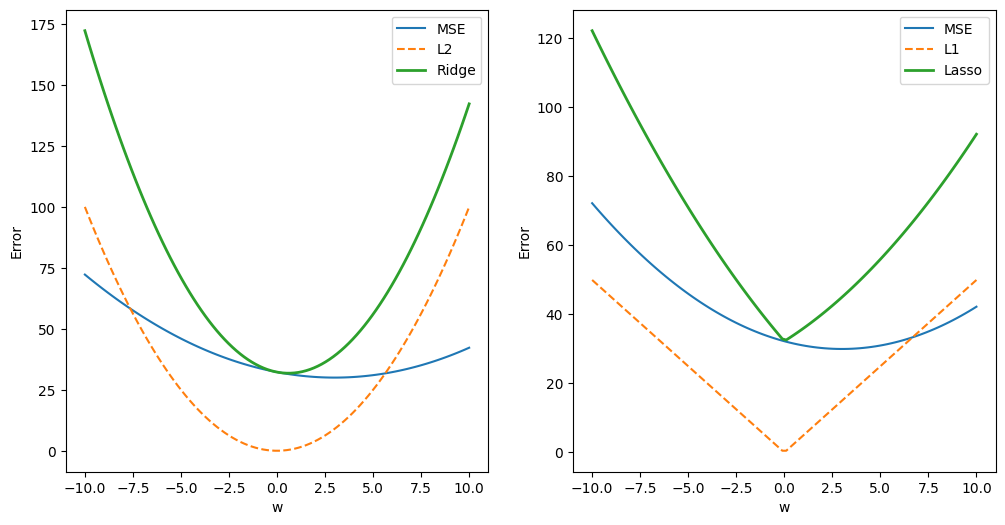

In [8]:
fig = plt.figure(figsize=[12,6])

rng = np.linspace(-10,10,100)
mse = (0.5*(rng-3))**2 + 30
l2 = rng**2
l1 = 5*np.abs(rng)
ridge = mse + l2
lasso = mse + l1

plt.subplot(1,2,1)
plt.plot(rng,mse,label='MSE')
plt.plot(rng,l2,'--',label='L2')
plt.plot(rng,ridge, lw=2, label='Ridge')
plt.xlabel('w'); plt.ylabel('Error')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rng,mse,label='MSE')
plt.plot(rng,l1,'--',label='L1')
plt.plot(rng,lasso, lw=2, label='Lasso')
plt.xlabel('w'); plt.ylabel('Error')
plt.legend()

릿지와 라쏘회귀의 Error의 최소값 위치가 w값이 0쪽으로 치우쳐짐을 확인할 수 있습니다. \
또한, 라쏘는 릿지보다 최소값 근처에서 기울기가 큼을 알 수 있습니다. \
두 식 모두 경사하강법을 사용하기 때문에 릿지는 w가 천천히 0으로 향하지만 라쏘는 w가 빨리 0으로 향하는 것을 확인할 수 있습니다. \
또한 규제의 강도를 의미하는 alpha값이 커질수록 w가 0으로 향하는 정도와 속도가 커집니다.


사이킷런을 활용하면 보다 쉽게 라쏘, 릿지 회귀를 수행해볼 수 있습니다.

### 2.2 라쏘회귀(Lasso Regression)

In [9]:
# 정규화
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

lasso = Lasso().fit(X_train_scaled, y_train)
predLasso = lasso.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, predLasso))
r2 = r2_score(y_test, predLasso)
print('결정계수 :', r2)
print('평균제곱근오차 : ', rmse)
print('훈련 세트 점수 : {:.2f}'.format(lasso.score(X_train_scaled, y_train)))
print('테스트 세트 점수 : {:.2f}'.format(lasso.score(X_test_scaled, y_test)))

결정계수 : 0.6326679325625943
평균제곱근오차 :  48.056034206462314
훈련 세트 점수 : 0.68
테스트 세트 점수 : 0.63


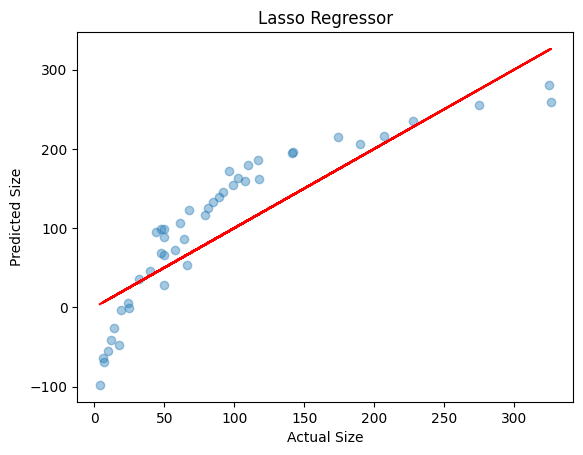

In [11]:
plt.scatter(y_test, predLasso, alpha=0.4)
plt.plot(y_test, y_test, color='r')
plt.xlabel("Actual Size")
plt.ylabel("Predicted Size")
plt.title("Lasso Regressor")
plt.show()

### 2.3 릿지회귀(Ridge Regression)

---

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)
predRidge = ridge.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, predRidge))
r2 = r2_score(y_test, predRidge)

print('결정계수 :', r2)
print('평균제곱근오차 : ', rmse)
print('훈련 세트 점수 : {:.2f}'.format(ridge.score(X_train_scaled, y_train)))
print('테스트 세트 점수 : {:.2f}'.format(ridge.score(X_test_scaled, y_test)))


결정계수 : 0.6267133631070069
평균제곱근오차 :  48.44397017235621
훈련 세트 점수 : 0.68
테스트 세트 점수 : 0.63


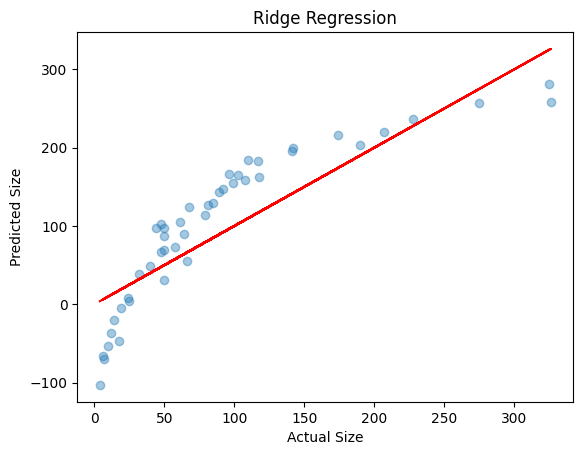

In [13]:
plt.scatter(y_test, predRidge, alpha=0.4)
plt.plot(y_test, y_test, color='r')
plt.xlabel("Actual Size")
plt.ylabel("Predicted Size")
plt.title("Ridge Regression")
plt.show()

### 2.4 선형회귀와 비교

---

선형회귀와 비교해보도록 하겠습니다. \
다중선형회귀의 결과를 보면 훈련세트와 테스트세트의 차이가 0.11정도나타납니다. \
앞서 살펴본 라쏘, 릿지 회귀의 결과와는 다르게 훈련세트와 테스트 세트와의 격차가 크게 나타납니다. \
즉, **오버피팅**이 발생합니다. \
일반화 성능을 올리면서, 오버피팅을 방지하는 릿지, 라쏘 회귀의 특징이 잘 나타난것을 확인할 수 있습니다.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
r2 = r2_score(y_test, lr_pred)

print('결정계수 :', r2)
print('평균제곱근오차 : ', rmse)
print('훈련 세트 점수 : {:.2f}'.format(lr.score(X_train_scaled, y_train)))
print('테스트 세트 점수 : {:.2f}'.format(lr.score(X_test_scaled, y_test)))

결정계수 : 0.5776680930313829
평균제곱근오차 :  51.528257116528266
훈련 세트 점수 : 0.69
테스트 세트 점수 : 0.58


### 2.5 K-fold cross validation에서 검증하기
---
지난 시간과 마찬가지로, K-fold cross validation을 수행하여 성능을 평가해 보겠습니다.

In [15]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
kf=KFold(n_splits=5) # 5개 set으로 나누기

models=[ ['LR', LinearRegression()],
        ['Ridge', Ridge()],
        ['Lasso', Lasso()],
       ]

result={} 
result_minmax={}  # mimnax scaled data 결과를 저장할 dict
result_sta={} # standard scaled data 결과를 저장할 dict

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler=MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax=scaler.transform(X_train)
    X_test_minmax= scaler.transform(X_test)
    
    scaler2=StandardScaler()
    scaler2.fit(X_train)
    X_train_sta=scaler2.transform(X_train)
    X_test_sta = scaler2.transform(X_test)
    
    for model_name, model in models:
        y_pred=model.fit(X_train,y_train).predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        if model_name not in result:  # 처음에는 dictionary가 비어 있으므로 
            result[model_name]=0
        result[model_name]= result[model_name]+rmse

        #minmax scaler 부분
        y_pred_minmax=model.fit(X_train_minmax,y_train).predict(X_test_minmax)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_minmax))
        if model_name not in result_minmax:  # 처음에는 dictionary가 비어 있으므로 
            result_minmax[model_name]=0
        result_minmax[model_name]= result_minmax[model_name]+rmse
        
        #standard scaler 부분
        y_pred_sta=model.fit(X_train_sta,y_train).predict(X_test_sta)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_sta))
        if model_name not in result_sta:  # 처음에는 dictionary가 비어 있으므로 
            result_sta[model_name]=0
        result_sta[model_name]= result_sta[model_name]+rmse
        
        
for key in result:
    result[key]=round(result[key]/5,4)
    result_minmax[key]=round(result_minmax[key]/5,4)
    result_sta[key]=round(result_sta[key]/5,4)
    
print('Raw data')
print(result)
print('\nMinmax')
print(result_minmax)
print('\nStandard')
print(result_sta)


Raw data
{'LR': 66.1868, 'Ridge': 66.1796, 'Lasso': 66.1429}

Minmax
{'LR': 66.1868, 'Ridge': 65.9707, 'Lasso': 66.0674}

Standard
{'LR': 66.1868, 'Ridge': 66.1518, 'Lasso': 66.0912}


정말 미세하게 감소한 것을 확인했습니다. \
${\lambda}$ 를 강의 시간에 배웠는데, 이 부분을 customize하지 않았기 때문에 실제 Regularization의 중요한 요소를 고려하지 않았습니다.\
이 부분에 대한 실험은 뒷부분에 수행하겠습니다.\
참고로, sklearn에서는 $\lambda$ 대신 $\alpha$로 표현합니다.

## 3. MLP 모델 적용

---

사이킷런은 sklearn.neural_network 모듈 아래에 분류 작업을 위한 MLPClassifier, 회귀 작업을 위한 MLPRegressor를 제공합니다. \
이를 이용하면 손쉽게 MLP모델을 적용할 수 있습니다.

### 3.1 필요한 라이브러리 불러오기

---

In [16]:
from sklearn.neural_network import MLPRegressor
# MLP를 활용한 회귀(Regressor)
from sklearn import metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1 )
X.shape
print('학습 데이터 :' ,X_train.shape)
print('테스트 데이터 : ', X_test.shape)
scaler=MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

학습 데이터 : (180, 3)
테스트 데이터 :  (45, 3)


### 3.2 모델 생성

---

총 5개의 히든레이어 층을 쌓고 800회 학습을 실시하겠습니다. \
활성화 함수는 'ReLU'를, 옵티마이저는 'Adam'을 사용합니다.

In [17]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(300, 200, 150, 100, 50),
                       max_iter = 800,activation = 'relu',
                       solver = 'adam', verbose = True)

# activation : 직전 레이어에서 받은 값에 weight를 곱해서 더한 후 통과하는 함수
# relu: 0보다 크면 x 그대로 보내고, 0보다 작으면 0
# adam : 최적화(Optimization) 방식 선정, 
# max_iter : 최대 학습 횟수 (전체 데이터를 800번 보고 나면 종료)
# verbose: True로 설정하면 학습 과정을 다 로그로 출력하는 argument (기본값 false)

### 3.3 훈련과 평가

---

모델을 학습하고 테스트 데이터로 모델을 평가해보겠습니다.

In [18]:
mlp_reg.fit(X_train_scaled, y_train)

y_pred = mlp_reg.predict(X_test_scaled)

Iteration 1, loss = 13984.39854390
Iteration 2, loss = 13966.87385925
Iteration 3, loss = 13948.76333760
Iteration 4, loss = 13931.22487712
Iteration 5, loss = 13911.69029966
Iteration 6, loss = 13888.99888811
Iteration 7, loss = 13861.90264318
Iteration 8, loss = 13829.27971918
Iteration 9, loss = 13791.08069963
Iteration 10, loss = 13745.46162363
Iteration 11, loss = 13691.13800213
Iteration 12, loss = 13626.83088873
Iteration 13, loss = 13551.13805220
Iteration 14, loss = 13461.94666523
Iteration 15, loss = 13356.89652318
Iteration 16, loss = 13233.69891468
Iteration 17, loss = 13089.39420592
Iteration 18, loss = 12922.03298576
Iteration 19, loss = 12729.08880599
Iteration 20, loss = 12508.32890906
Iteration 21, loss = 12258.66008823
Iteration 22, loss = 11977.91499012
Iteration 23, loss = 11666.92503664
Iteration 24, loss = 11327.10822948
Iteration 25, loss = 10962.87599195
Iteration 26, loss = 10582.64649629
Iteration 27, loss = 10200.46361242
Iteration 28, loss = 9837.03652104
It

Iteration 267, loss = 64.18407407
Iteration 268, loss = 64.01568296
Iteration 269, loss = 63.86557859
Iteration 270, loss = 63.69712957
Iteration 271, loss = 63.52350976
Iteration 272, loss = 63.34666245
Iteration 273, loss = 63.19608074
Iteration 274, loss = 63.05382585
Iteration 275, loss = 62.87783527
Iteration 276, loss = 62.74563181
Iteration 277, loss = 62.63076417
Iteration 278, loss = 62.47847274
Iteration 279, loss = 62.29918883
Iteration 280, loss = 62.20500392
Iteration 281, loss = 62.01739882
Iteration 282, loss = 61.89775830
Iteration 283, loss = 61.77883690
Iteration 284, loss = 61.59267180
Iteration 285, loss = 61.47483957
Iteration 286, loss = 61.33777908
Iteration 287, loss = 61.20131486
Iteration 288, loss = 61.07802865
Iteration 289, loss = 60.95883814
Iteration 290, loss = 60.84165689
Iteration 291, loss = 60.70874777
Iteration 292, loss = 60.59294430
Iteration 293, loss = 60.48021324
Iteration 294, loss = 60.34871393
Iteration 295, loss = 60.23798632
Iteration 296,

Iteration 521, loss = 27.40913646
Iteration 522, loss = 27.38916956
Iteration 523, loss = 27.35465965
Iteration 524, loss = 27.21736152
Iteration 525, loss = 27.03991830
Iteration 526, loss = 26.75039609
Iteration 527, loss = 26.46716141
Iteration 528, loss = 26.26869400
Iteration 529, loss = 26.20314276
Iteration 530, loss = 26.24279042
Iteration 531, loss = 26.26521443
Iteration 532, loss = 26.21575380
Iteration 533, loss = 26.02877983
Iteration 534, loss = 25.80437012
Iteration 535, loss = 25.54745771
Iteration 536, loss = 25.35768522
Iteration 537, loss = 25.29433712
Iteration 538, loss = 25.28515592
Iteration 539, loss = 25.32350987
Iteration 540, loss = 25.34540920
Iteration 541, loss = 25.32434233
Iteration 542, loss = 25.07348681
Iteration 543, loss = 24.70935434
Iteration 544, loss = 24.49289712
Iteration 545, loss = 24.47778024
Iteration 546, loss = 24.51554651
Iteration 547, loss = 24.43798087
Iteration 548, loss = 24.23137558
Iteration 549, loss = 24.00862870
Iteration 550,

Iteration 787, loss = 10.46689964
Iteration 788, loss = 10.56244397
Iteration 789, loss = 10.59356247
Iteration 790, loss = 10.55093321
Iteration 791, loss = 10.43458469
Iteration 792, loss = 10.28045900
Iteration 793, loss = 10.10150428
Iteration 794, loss = 9.98256655
Iteration 795, loss = 9.95208711
Iteration 796, loss = 9.99220320
Iteration 797, loss = 10.08199426
Iteration 798, loss = 10.19488969
Iteration 799, loss = 10.30101868
Iteration 800, loss = 10.40500825


/home/elicer/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


Verbose로 실제 학습 상황을 확인한 결과, max_iteration으로 설정한 800보다 일찍 학습이 종료되는 것을 확인할 수 있습니다.\
그 이유는 Training Loss가 tol(=0.0001) 이상 감소하지 않는 상황이 10번 연속으로 지속되면 더 이상의 학습이 무의미하다고 보고 학습을 종료하는 $Early Stopping$ 때문입니다. \
이 내용은 6일차에 자세히 배울 예정입니다.

* 다시 실행했을 때, 더 오래 학습이 진행되는 경우도 존재합니다.

실제 타깃값과 예측값 결과를 확인하고 그래프로 표현해보겠습니다.

In [19]:
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp.head()

,Actual,Predicted
39,4,2.382451
166,32,28.849084
93,92,90.262909
62,58,55.792880
195,6,10.197809


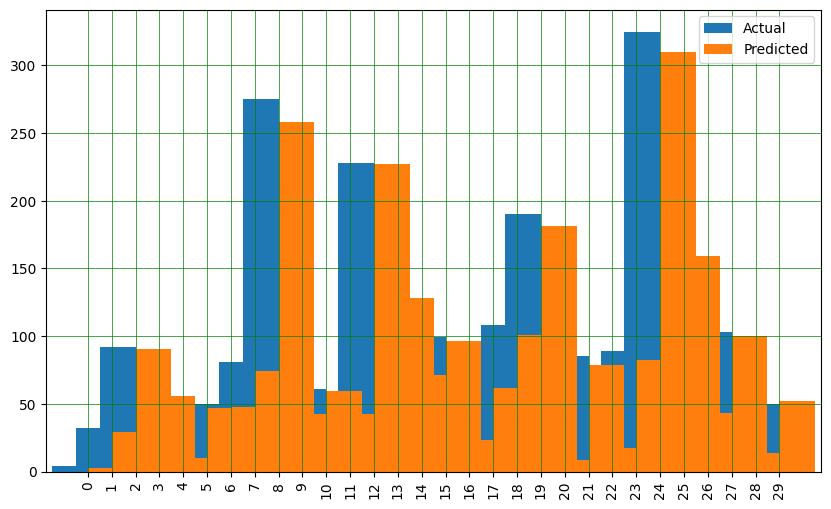

In [20]:
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6), width = 3, use_index = False)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

값마다 정확하게 예측하거나 근사치에 예측한 값이 있는 반면 차이가 많이 나는 데이터도 존재합니다.
평가표인 MAE, MSE, RMSE를 출력해보겠습니다.

In [21]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.6542003565490235
Mean Squared Error: 62.87854962605865
Root Mean Squared Error: 7.929599588003082


사이킷런(sklearn) 이외에 본격적인 딥러닝 프레임워크(tensorflow)를 이용한 딥러닝 모델은 이후 차시에서 다뤄볼 예정입니다. \
마지막으로 Loss 커브를 통해 훈련마다 Loss가 어떻게 감소했는지 살펴보겠습니다.

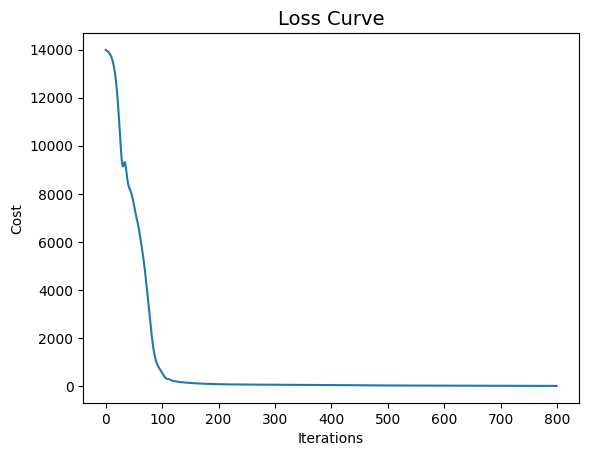

In [22]:
plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

반복 횟수가 증가할 때마다 Loss가 감소하는 모습을 보입니다. LOSS가 감소했으니 정상적으로 훈련이 진행되었다는 것을 알 수 있습니다.

## 4. 예제 데이터 적용(보스턴 집값 데이터)

---

이전 시간에 전처리한 보스턴 집값 데이터를 이용해 선형회귀, 라쏘 릿지 회귀, MLP모델 실습 및 회귀 분석에 대한 통계량 지표 확인 등을 수행해보겠습니다.

### 4.1 데이터 불러오기

---

모델 학습에 필요한 데이터를 불러옵니다. \
이전에 사용했던 전처리된 보스턴 집값데이터를 불러오겠습니다. 총 40개의 컬럼과 1458개의 데이터로 이루어져있습니다.

In [23]:
train = pd.read_csv('train_preprocessing.csv')

In [24]:
train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [25]:
train.head()

,TotalSF,OverallQual,Total_sqr_footage,GrLivArea,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,1stFlrSF,FullBath,...,Foundation_CBlock,MSZoning_RM,MasVnrType_None,GarageType_Detchd,GarageFinish,HeatingQC,KitchenQual,ExterQual,BsmtQual,SalePrice
0,14.976591,7,14.781997,13.698888,2.0,3.5,548.0,4006,11.692623,2,...,0,0,0,0,1.194318,0,1.194318,1.194318,2,208500
1,14.923100,6,14.540127,12.792276,2.0,2.5,460.0,3952,12.792276,2,...,1,0,1,0,1.194318,0,1.540963,1.540963,2,181500
2,15.149678,7,14.585277,13.832085,2.0,3.5,608.0,4003,11.892039,2,...,0,0,0,0,1.194318,0,1.194318,1.194318,2,223500
3,14.857121,7,14.076603,13.711364,3.0,2.0,642.0,3885,12.013683,1,...,0,0,1,1,1.540963,2,1.194318,1.540963,4,140000
4,15.852312,8,15.323415,14.480029,3.0,3.5,836.0,4000,12.510588,2,...,0,0,0,0,1.194318,0,1.194318,1.194318,2,250000


### 4.2 데이터 분리(X, y) 훈련 세트와 테스트 세트 생성

---

In [26]:
X = train.iloc[:, :39]
y = train['SalePrice']

X.count()

TotalSF                 1458
OverallQual             1458
Total_sqr_footage       1458
GrLivArea               1458
GarageCars              1458
Total_Bathrooms         1458
GarageArea              1458
YrBltAndRemod           1458
1stFlrSF                1458
FullBath                1458
YearBuilt               1458
YearRemodAdd            1458
TotRmsAbvGrd            1458
Foundation_PConc        1458
hasfireplace            1458
Fireplaces              1458
TotalBsmtSF             1458
OpenPorchSF             1458
MasVnrArea              1458
GarageType_Attchd       1458
LotArea                 1458
Total_porch_sf          1458
LotFrontage             1458
CentralAir              1458
WoodDeckSF              1458
Neighborhood_NridgHt    1458
Exterior2nd_VinylSd     1458
Exterior1st_VinylSd     1458
GarageYrBlt             1458
GarageType_None         1458
Foundation_CBlock       1458
MSZoning_RM             1458
MasVnrType_None         1458
GarageType_Detchd       1458
GarageFinish  

In [27]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1 )
X.shape
print('학습 데이터 :' ,X_train.shape)
print('테스트 데이터 : ', X_test.shape)

학습 데이터 : (1166, 39)
테스트 데이터 :  (292, 39)


### 4.3 선형회귀(Linear Regression) 

---

마찬가지로 선형회귀를 수행하면 아래와 같은 결과가 나옵니다. 훈련세트와 테스트 세트의 결과가 꽤 높게 나오는 모습을 알 수 있습니다.
두 데이터간의 스코어 격차가 심하지 않고, 거의 동일하게 나오고 있습니다.

In [28]:
lr = LinearRegression().fit(X_train, y_train)

lr_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
r2 = r2_score(y_test, lr_pred)

print('결정계수 :', r2)
print('평균제곱근오차 : ', rmse)
print('훈련 세트 점수 : {:.2f}'.format(lr.score(X_train, y_train)))
print('테스트 세트 점수 : {:.2f}'.format(lr.score(X_test, y_test)))

결정계수 : 0.8649195602534191
평균제곱근오차 :  28334.18607583915
훈련 세트 점수 : 0.85
테스트 세트 점수 : 0.86


그래프 또한 비교적 선형의 모습을 띄고 있습니다. 예측이 비교적 잘 되고 있는 모습을 볼 수 있습니다.

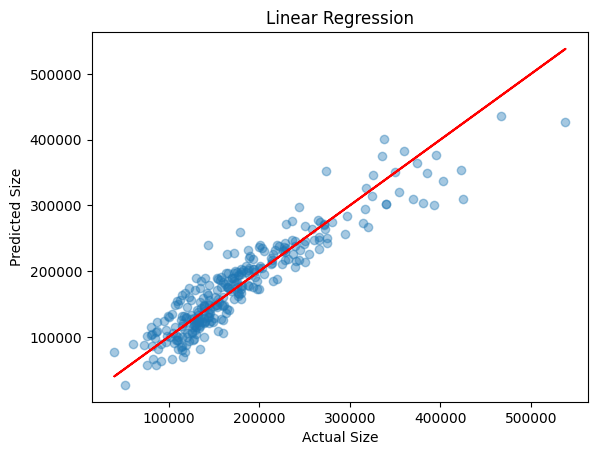

In [29]:
plt.scatter(y_test, lr_pred, alpha=0.4)
plt.plot(y_test, y_test, color='r')
plt.xlabel("Actual Size")
plt.ylabel("Predicted Size")
plt.title("Linear Regression")
plt.show()

### 4.4 선형회귀 통계량 살펴보기

---

OLS 회귀분석를 사용하면 summary()명령어를 통해 통계량 지표를 산출할 수 있습니다. \
stat의 OLS회귀분석은 잔차제곱합(RSS: Residual Sum of Squares)를 최소화하는 가중치 벡터를 구하는 방법입니다.

In [30]:
import statsmodels.api as sm
X_train_beta = sm.add_constant(X_train) ### 선형 회귀 식의 beta 0를 만드는 과정 
model = sm.OLS(y_train, X_train_beta, axis = 1) ## OLS data modeling 
model_trained = model.fit() ## 모델 fitting
model_residuals = model_trained.resid ### 모델의 잔차(예측값 - 타겟값)

/home/elicer/.local/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['axis']
  warnings.warn(msg, ValueWarning)


In [31]:
model_trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     168.8
Date:                Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                        06:26:23   Log-Likelihood:                -13697.
No. Observations:                1166   AIC:                         2.747e+04
Df Residuals:                    1126   BIC:                         2.768e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.032e+08   5.93e+07     -1.739      0.082    -2.2e+08    1.32e+07
TotalSF               1.565e+04   6421.233      2.438      0.015    3054.375    2.83e+04
OverallQual           1.497e+04   1296.237     11.549      0.000    1.24e+04    1.75e+04
Total_sqr_footage     1.212e+04   2006.697      6.040      0.000    8183.946    1.61e+04
GrLivArea              982.3630   4574.463      0.215      0.830   -7993.068    9957.794
GarageCars            8300.2396   3185.695      2.605      0.009    2049.674    1.46e+04
Total_Bathrooms       2321.2169   2421.153      0.959      0.338   -2429.263    7071.697
GarageArea               5.3858     10.901      0.494      0.621     -16.003      26.775
YrBltAndRemod        -1.481e+04   8593.063     -1.724      0.085   -3.17e+04    2048.252
1stFlrSF              1511.3952   2249.243      0.672      0.502   -2901.784    5924.574
FullBath             -1697.7656   3201.870     -0.530      0.596   -7980.068    4584.537
YearBuilt             9.315e+06   5.38e+06      1.732      0.083   -1.23e+06    1.99e+07
YearRemodAdd          1.497e+04   8609.271      1.739      0.082   -1917.831    3.19e+04
TotRmsAbvGrd         -3531.7649   6160.964     -0.573      0.567   -1.56e+04    8556.497
Foundation_PConc      3239.1068   4537.019      0.714      0.475   -5662.855    1.21e+04
hasfireplace         -1.892e+04   6449.378     -2.934      0.003   -3.16e+04   -6268.792
Fireplaces            2.694e+04   7808.537      3.450      0.001    1.16e+04    4.23e+04
TotalBsmtSF          -1739.8209   1184.995     -1.468      0.142   -4064.868     585.226
OpenPorchSF            517.5491    411.038      1.259      0.208    -288.937    1324.035
MasVnrArea            2875.0036    801.495      3.587      0.000    1302.411    4447.596
GarageType_Attchd     -627.7015   3753.238     -0.167      0.867   -7991.829    6736.426
LotArea               4692.5994    678.533      6.916      0.000    3361.268    6023.931
Total_porch_sf        -668.8807    451.023     -1.483      0.138   -1553.821     216.060
LotFrontage           1225.0184   2171.487      0.564      0.573   -3035.597    5485.634
CentralAir            5873.0324   6150.896      0.955      0.340   -6195.475    1.79e+04
WoodDeckSF             910.4509    339.307      2.683      0.007     244.706    1576.196
Neighborhood_NridgHt  1.543e+04   4943.476      3.121      0.002    5729.750    2.51e+04
Exterior2nd_VinylSd   1.009e+04   1.02e+04      0.993      0.321   -9855.446       3e+04
Exterior1st_VinylSd  -1.278e+04   1.02e+04     -1.255      0.210   -3.28e+04    7200.826
GarageYrBlt          -1955.6223   5.18e+04     -0.038      0.970   -1.04e+05    9.97e+04
GarageType_None      -1.895e+04   7.31e+05     -0.026      0.979   -1.45e+06    1.41e+06
Foundation_CBlock     -577.2248   4049.073     -0.143    

- 통계량을 통해 **coef(각 변수별 계수 추정치)**, **std err (계수 추정치의 표준편차)**, **t(t검정 통계량 값)**, **P>|t|(귀무가설이 맞다고 가정할 때 대립가설이 실제로 관측될 확률)** 등 다양한 지표를 이용해 예측 정확도 향상에 사용할 수 있습니다.

### 4.5 라쏘회귀(Lasso Regression) and 릿지회귀(Ridge Regression) in Boston

---

보스턴 집값 데이터를 활용해 라쏘 회귀와 릿지 회귀를 각각 수행해보겠습니다.

In [32]:
# 라쏘 회귀
lasso = Lasso().fit(X_train, y_train)
predLasso = lasso.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predLasso))
r2 = r2_score(y_test, predLasso)
print('결정계수 :', r2)
print('평균제곱근오차 : ', rmse)
print('훈련 세트 점수 : {:.2f}'.format(lasso.score(X_train, y_train)))
print('테스트 세트 점수 : {:.2f}'.format(lasso.score(X_test, y_test)))

결정계수 : 0.8619414285147524
평균제곱근오차 :  28644.826523619984
훈련 세트 점수 : 0.85
테스트 세트 점수 : 0.86


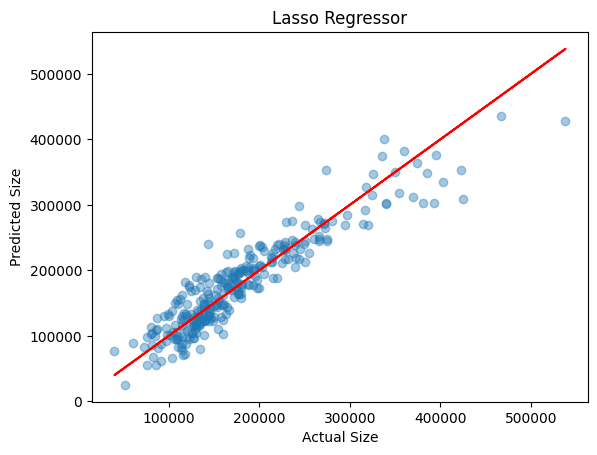

In [33]:
plt.scatter(y_test, predLasso, alpha=0.4)
plt.plot(y_test, y_test, color='r')
plt.xlabel("Actual Size")
plt.ylabel("Predicted Size")
plt.title("Lasso Regressor")
plt.show()

In [34]:
# 릿지회귀
ridge = Ridge()
ridge.fit(X_train, y_train)
predRidge = ridge.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predRidge))
r2 = r2_score(y_test, predRidge)

print('결정계수 :', r2)
print('평균제곱근오차 : ', rmse)
print('훈련 세트 점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
print('테스트 세트 점수 : {:.2f}'.format(ridge.score(X_test, y_test)))

결정계수 : 0.8621943538344863
평균제곱근오차 :  28618.575624781988
훈련 세트 점수 : 0.85
테스트 세트 점수 : 0.86


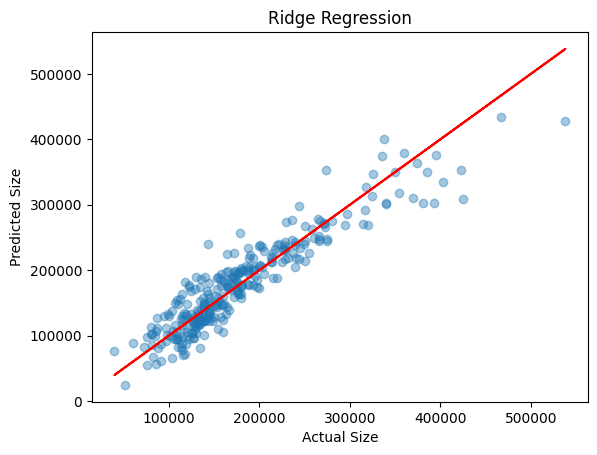

In [35]:
plt.scatter(y_test, predRidge, alpha=0.4)
plt.plot(y_test, y_test, color='r')
plt.xlabel("Actual Size")
plt.ylabel("Predicted Size")
plt.title("Ridge Regression")
plt.show()

두 모델 다 선형회귀 모델보다 점수가 오차가 비교적 크고 결정계수도 낮게 나오고 있습니다. \
alpha값을 조정하거나 변수중요도에 따른 변수를 다시 선정한다면 더 좋은 결과를 기대할 수도 있습니다.

### 4.6 Parameter Search in Ridge/Lasso 
---
Regularization을 수행했지만, 성능이 더 나빠졌습니다.\
위에서 설명한 것처럼 alpha값을 수정하여 성능 개선의 여지가 있는지 확인해 봅시다.\
참고로, Ridge()와 Lasso()의 alpha 기본값은 1 입니다.

In [36]:
for Alpha in [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]:
    ridge = Ridge(alpha=Alpha)
    ridge.fit(X_train, y_train)
    predRidge = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predRidge))
    r2 = r2_score(y_test, predRidge)
    print('Ridge',Alpha,'평균제곱근오차 : ', rmse)

print('')
for Alpha in [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]:
    lasso = Lasso(alpha=Alpha).fit(X_train, y_train)
    predLasso = lasso.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predLasso))
    r2 = r2_score(y_test, predLasso)
    print('Lasso',Alpha,'평균제곱근오차 : ', rmse)


Ridge 0.0001 평균제곱근오차 :  28492.715513281197
Ridge 0.0005 평균제곱근오차 :  28557.875139017844
Ridge 0.001 평균제곱근오차 :  28578.237200309977
Ridge 0.005 평균제곱근오차 :  28619.337267011942
Ridge 0.01 평균제곱근오차 :  28630.90758875205
Ridge 0.05 평균제곱근오차 :  28642.038980801724
Ridge 0.1 평균제곱근오차 :  28642.176530556695
Ridge 0.5 평균제곱근오차 :  28631.344767095256
Ridge 1 평균제곱근오차 :  28618.575624781988
Ridge 5 평균제곱근오차 :  28557.430227178873
Ridge 10 평균제곱근오차 :  28507.923568395443
Ridge 50 평균제곱근오차 :  28215.749050494574
Ridge 100 평균제곱근오차 :  28066.16775913138
Ridge 500 평균제곱근오차 :  28525.136046779986
Ridge 1000 평균제곱근오차 :  29549.379443484188
Ridge 5000 평균제곱근오차 :  35933.534916051336
Ridge 10000 평균제곱근오차 :  39758.077667873375

Lasso 0.0001 평균제곱근오차 :  28642.11919236869


/home/elicer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.471e+11, tolerance: 7.470e+08
  model = cd_fast.enet_coordinate_descent(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.471e+11, tolerance: 7.470e+08
  model = cd_fast.enet_coordinate_descent(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5

Lasso 0.0005 평균제곱근오차 :  28642.123342664552
Lasso 0.001 평균제곱근오차 :  28642.128530596296
Lasso 0.005 평균제곱근오차 :  28642.169937562194
Lasso 0.01 평균제곱근오차 :  28642.22152891213


/home/elicer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.470e+11, tolerance: 7.470e+08
  model = cd_fast.enet_coordinate_descent(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.468e+11, tolerance: 7.470e+08
  model = cd_fast.enet_coordinate_descent(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5

Lasso 0.05 평균제곱근오차 :  28642.63339000041
Lasso 0.1 평균제곱근오차 :  28643.150157559176
Lasso 0.5 평균제곱근오차 :  28645.55385000876
Lasso 1 평균제곱근오차 :  28644.826523619984
Lasso 5 평균제곱근오차 :  28634.590079986214
Lasso 10 평균제곱근오차 :  28622.993405487447
Lasso 50 평균제곱근오차 :  28563.382338882366
Lasso 100 평균제곱근오차 :  28544.56602368491
Lasso 500 평균제곱근오차 :  28507.809037622803
Lasso 1000 평균제곱근오차 :  28331.762881234736
Lasso 5000 평균제곱근오차 :  29922.04418917878
Lasso 10000 평균제곱근오차 :  32579.42391414196


## 5. 연습문제

---

### 5.1 릿지회귀(Ridge Regression)을 수행하는 코드를 작성하시오.

---

릿지회귀를 수행하는 코드를 작성하시오. 보스턴 집값 예측 데이터를 사용합니다.(X_train, y_train)

In [38]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge()
ridge.fit(X_train, y_train)
predRidge = ridge.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test , predRidge))
r2 = r2_score(y_test, predRidge)

print('결정계수 :', r2)
print('평균제곱근오차 : ', mse)
print('훈련 세트 점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
print('테스트 세트 점수 : {:.2f}'.format(ridge.score(X_test, y_test)))

결정계수 : 0.8621943538344863
평균제곱근오차 :  28618.575624781988
훈련 세트 점수 : 0.85
테스트 세트 점수 : 0.86


### 5.2 사이킷런의 MLP 모델을 수행하는 코드를 완성하시오.

---

MLP모델을 통해 잉크젯 라인두께예측 데이터를 활용합니다.
- 아래 코드를 먼저 실행 후 빈칸을 채워 모델이 수행하능하도록 만들어주세요.
- 은닉층 지정과 횟수를 지정하는 파라미터 이름을 채워주세요. 활성함수는 'relu', 옵티마이저는 'adam'을 사용합니다.
- 테스트 데이터의 결과를 예측하는 코드를 완성하세요.
- 마지막으로 코드 결과를 시각화해서 확인해보세요.

In [39]:
df = pd.read_csv('InkjetDB_preprocessing.csv') # 데이터 불러오기
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# X, y
X = df.iloc[:, :3]
y = df['PatternSize']

# 훈련, 테스트 세트 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1 )
X.shape
print('학습 데이터 :' ,X_train.shape)
print('테스트 데이터 : ', X_test.shape)

# 정규화
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

학습 데이터 : (180, 3)
테스트 데이터 :  (45, 3)


/home/elicer/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


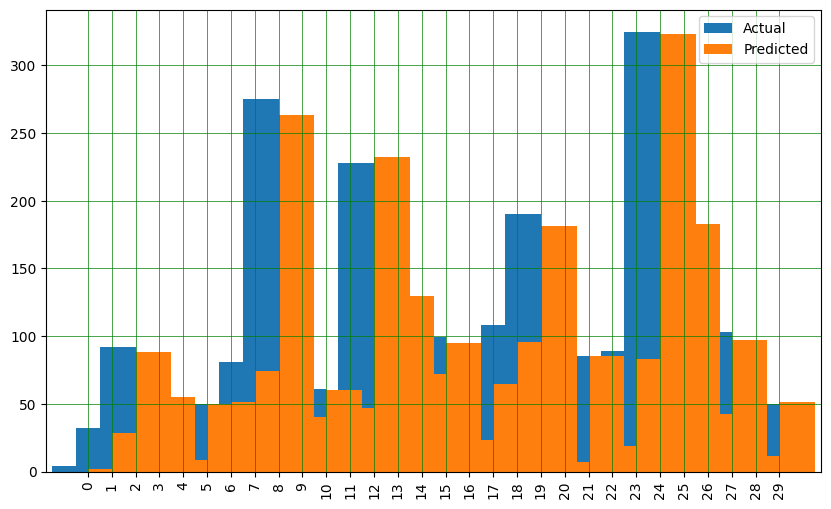

In [42]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(300, 200, 150, 100, 50),
                        max_iter = 800, activation = 'relu',
                       solver = 'adam')

mlp_reg.fit(X_train_scaled, y_train)

y_pred = mlp_reg.predict(X_test_scaled)

#결과 시각화
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6), width = 3, use_index = False)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### 5.3 OLS 회귀를 수행하고 통계량을 확인하는 코드를 작성하시오.

---

최소자승법(OLS)를 활용하는 회귀분석을 수행하는 코드를 작성하고 주요 통계량을 확인하는 코드를 완성합니다. 
- statsmodels를 이용합니다.
- 선형 회귀 식의 beta 0를 만드는 코드를 완성합니다.
- 모델을 훈련합니다.
- 모델의 잔차(예측값 - 타겟값)를 확인하는 코드를 작성합니다,
- 마지막으로 통계량 지표를 산출해 확인합니다.

In [46]:
import statsmodels.api as sm
X_train_beta = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_beta, axis = 1) 
model_trained = model.fit()
model_residuals = model_trained.resid

/home/elicer/.local/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['axis']
  warnings.warn(msg, ValueWarning)


In [47]:
#통계량 확인
model_trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PatternSize   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     128.5
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           4.14e-44
Time:                        06:33:42   Log-Likelihood:                -1019.9
No. Observations:                 180   AIC:                             2048.
Df Residuals:                     176   BIC:                             2061.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           343.9977     37.627      9.142      0.000     269.741     418.255
Viscosity       -39.5829      2.873    -13.778      0.000     -45.253     -33.913
Velocity         18.0883      4.684      3.862      0.000       8.844      27.333
PrintingSpeed    -0.8621      0.078    -11.034      0.000      -1.016      -0.708
==============================================================================
Omnibus:                      110.657   Durbin-Watson:                   2.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              646.871
Skew:                           2.354   Prob(JB):                    3.42e-141
Kurtosis:                      11.005   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 6. 최적의 Parameter 탐색

---

### 6.1 잉크젯 데이터에서 Parameter 바꿔 보기

Inkjet dataset에 대해 최적의 lambda값을 찾아보도록 하겠습니다.

In [48]:
import pandas as pd
from sklearn.linear_model import Ridge,Lasso
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('InkjetDB_preprocessing.csv')
# 데이터 불러오기

X = df.iloc[:, :3]
y = df['PatternSize']
# X y 나누기

kf=KFold(n_splits=5) # 5개 set으로 나누기

result_Ridge={}
result_Lasso={}
result_LR=0

Parameters=[0.00001,0.00005,0.0001,0.0005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]

for train_index, test_index in kf.split(X): # kf의 결과로 train, test에 해당하는 index가 5번 바뀜

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler=MinMaxScaler()
    scaler.fit(X_train)
    X_train_minmax=scaler.transform(X_train)
    #중요
    X_test_minmax= scaler.transform(X_test)
    for Alpha in Parameters:
        
        ridge=Ridge(alpha=Alpha)
        ridge.fit(X_train_minmax,y_train)
        predRidge=ridge.predict(X_test_minmax)
        rmse= np.sqrt(mean_squared_error(y_test,predRidge))
        if Alpha not in result_Ridge:
            result_Ridge[Alpha]=0
        result_Ridge[Alpha]=result_Ridge[Alpha]+rmse
        
        lasso=Lasso(alpha=Alpha)
        lasso.fit(X_train_minmax,y_train)
        predLasso=lasso.predict(X_test_minmax)
        rmse=np.sqrt(mean_squared_error(y_test,predLasso))
        if Alpha not in result_Lasso:
            result_Lasso[Alpha]=0
        result_Lasso[Alpha]=result_Lasso[Alpha]+rmse
        
    lr=LinearRegression()
    lr.fit(X_train_minmax,y_train)
    predlr=lr.predict(X_test_minmax)
    rmse=np.sqrt(mean_squared_error(y_test,predlr))
    result_LR+=rmse

for alpha in result_Lasso:
    result_Lasso[alpha]=round(result_Lasso[alpha]/5,4)
    result_Ridge[alpha]=round(result_Ridge[alpha]/5,4)
result_LR=round(result_LR/5,4)

print(result_LR)
print('Lasso(L1 Norm)',result_Lasso)
print('Ridge(L2 Norm)', result_Ridge)


86.3824
Lasso(L1 Norm) {1e-05: 86.3824, 5e-05: 86.3824, 0.0001: 172.7646, 0.0005: 172.7639, 0.001: 86.3815, 0.005: 86.378, 0.01: 86.3735, 0.05: 86.3388, 0.1: 86.2968, 0.5: 86.0107, 1: 85.77}
Ridge(L2 Norm) {1e-05: 86.3824, 5e-05: 86.3824, 0.0001: 172.7647, 0.0005: 172.7645, 0.001: 86.3821, 0.005: 86.381, 0.01: 86.3796, 0.05: 86.3687, 0.1: 86.3558, 0.5: 86.276, 1: 86.2303}


Scaler에 통과시킨 후에는 Lambda=1 근처의 Ridge/Lasso 성능이 일반 LR보다 좋은 것을 확인할 수 있습니다. 즉 Lambda=1일 경우 데이터가 Normalization되어 있을 때 일반적으로 성능이 좋은 것을 알 수 있습니다.

### 6.2 보스턴 집값 데이터에서 Scaler 설정 후 Parameter 바꿔 보기

Boston Housing dataset에 대해 최적의 lambda값을 찾아보도록 하겠습니다.

In [49]:
import warnings
warnings.filterwarnings(action='ignore') # warning 무시

In [50]:
train = pd.read_csv('train_preprocessing.csv')
train.drop(['Unnamed: 0'], axis=1, inplace=True)
train
X=train.iloc[:,:39]
y=train.iloc[:,39]

kf=KFold(5)

result_Ridge={}
result_Lasso={}
result_LR=0

Parameters=[0.00001,0.00005,0.0001,0.0005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100]

for train_index, test_index in kf.split(X): # kf의 결과로 train, test에 해당하는 index가 5번 바뀜

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler=MinMaxScaler()
    scaler.fit(X_train)
    X_train_minmax=scaler.transform(X_train)
    X_test_minmax=scaler.transform(X_test)
    for Alpha in Parameters:        
        ridge=Ridge(alpha=Alpha,max_iter=1000,tol=0.001)
        ridge.fit(X_train_minmax,y_train)
        predRidge=ridge.predict(X_test_minmax)
        rmse= np.sqrt(mean_squared_error(y_test,predRidge))
        if Alpha not in result_Ridge:
            result_Ridge[Alpha]=0
        result_Ridge[Alpha]=result_Ridge[Alpha]+rmse
        
        lasso=Lasso(alpha=Alpha,max_iter=1000,tol=0.001)
        lasso.fit(X_train_minmax,y_train)
        predLasso=lasso.predict(X_test_minmax)
        rmse=np.sqrt(mean_squared_error(y_test,predLasso))
        if Alpha not in result_Lasso:
            result_Lasso[Alpha]=0
        result_Lasso[Alpha]=result_Lasso[Alpha]+rmse
    lr=LinearRegression()
    lr.fit(X_train_minmax,y_train)
    predlr=lr.predict(X_test_minmax)
    rmse=np.sqrt(mean_squared_error(y_test,predlr))
    result_LR+=rmse

for alpha in result_Lasso:
    result_Lasso[alpha]=round(result_Lasso[alpha]/5,4)
    result_Ridge[alpha]=round(result_Ridge[alpha]/5,4)
result_LR=round(result_LR/5,4)    

print(result_LR)
print('Lasso(L1 Norm)',result_Lasso)
print('Ridge(L2 Norm)', result_Ridge)

30913.253
Lasso(L1 Norm) {1e-05: 30967.6257, 5e-05: 30967.6256, 0.0001: 61935.2511, 0.0005: 61935.2493, 0.001: 30967.6236, 0.005: 30967.6148, 0.01: 30967.6039, 0.05: 30967.5171, 0.1: 30967.4099, 0.5: 30966.591, 1: 30964.5111, 5: 30949.8544, 10: 30939.4026, 50: 30908.5876, 100: 31008.8221}
Ridge(L2 Norm) {1e-05: 30912.4967, 5e-05: 30911.3672, 0.0001: 61824.3604, 0.0005: 61852.9945, 0.001: 30936.6486, 0.005: 30956.4899, 0.01: 30960.6534, 0.05: 30959.438, 0.1: 30955.0428, 0.5: 30941.3203, 1: 30949.4324, 5: 31368.2355, 10: 31997.2635, 50: 35615.1877, 100: 38642.2136}


In [51]:
y_train

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1162    108959
1163    194000
1164    233170
1165    245350
1166    173000
Name: SalePrice, Length: 1167, dtype: int64

Lasso와 Ridge의 최적 lambda값이 매우 다르게 나타났는데, 그 이유는  L1 Norm을 쓰는 Lasso보다, L2 Norm을 쓰는 Ridge의 Regulation이높은 파라미터에 대해서 더 크게 나타나기 때문입니다.

#### Inkjet dataset과 Boston dataset의 차이
Scaler를 사용한 후의 보스턴 집값 데이터는 [0,1]의 데이터로 십만 단위의 큰 숫자인 집값을 예측해야 하므로, 잉크젯 데이터보다 파라미터가 필연적으로 클 것입니다. \
따라서 Lasso의 경우 더 높은 Lambda값을 필요로 했고, Ridge의 경우 제곱에 비례하기 때문에 해당 파라미터가 0.00005인 경우에 최적의 값을 보여줍니다.